<a href="https://colab.research.google.com/github/dlskawns/LG_Uplus_AI_Stage/blob/main/LG_Uplus_competition_NeuMF_payment_added.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -r "/content/drive/MyDrive/code/requirements.txt"

In [2]:
# 패키지 로드
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict
import os, random

from scipy import sparse
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.nn.init import normal_
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import plotnine
from plotnine import *

In [3]:
# 경로 설정
data_path = '../data'
saved_path = './saved'
output_path = './submission'

### 데이터 불러오기
- history_data : 시청 시작 데이터
- profile_data : 프로필 정보 
- meta_data : 콘텐츠 일반 메타 정보

# 오리지날 학습 및 검증 데이터 생성 
- train : 시청 이력의 80%를 사용 
- valid : 시청 이력의 20%를 사용 

In [4]:
history_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/history_data.csv'), encoding='utf-8')
profile_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/profile_data.csv'), encoding='utf-8')
meta_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/meta_data.csv'), encoding='utf-8')
buy_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/buy_data.csv'), encoding='utf-8')
watch_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/watch_e_data.csv'), encoding='utf-8')
search_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/search_data.csv'), encoding='utf-8')
metap_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/meta_data_plus.csv'), encoding='utf-8')

In [5]:
buy_df.head(2)


,profile_id,ss_id,log_time,act_target_dtl,album_id,payment
0,255,20220426153942,20220426154128,MKID004,3767,500
1,1603,20220309163919,20220309164043,MKID004,1640,300


In [12]:
print(search_df.shape)
print(search_df.profile_id.nunique())
len(search_df.drop_duplicates())

(6474, 5)
644


5825

In [13]:
profile_df.profile_id.nunique()

8311

In [ ]:
metap_df.keyword

In [14]:
# 하이퍼파라미터 
class cfg: 
    gpu_idx = 0
    device = torch.device("cuda:{}".format(gpu_idx) if torch.cuda.is_available() else "cpu")
    top_k = 25
    seed = 42
    neg_ratio = 100
    test_size = 0.2

In [15]:
# 시드 고정 
def seed_everything(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
seed_everything(cfg.seed)

In [16]:
# 초기 데이터 처리
h_df = history_df[['profile_id','log_time','album_id']]
# meta = meta_df[['album_id','genre_mid','run_time']].drop_duplicates()
df = pd.merge(h_df, profile_df[['profile_id','sex','age']], 'left', on = 'profile_id')
df = pd.merge(df, meta_df, 'left', on = 'album_id')
view_cnts = df.groupby('profile_id')['album_id'].count()
df['views'] = df['profile_id'].map(lambda x: view_cnts[x])

In [17]:
df.shape

(1275380, 21)

In [20]:
search_df.head(3)

,profile_id,ss_id,log_time,act_target_dtl,album_id
0,59,20220303183951,20220303183914,MKID017,2141
1,59,20220303183951,20220303183914,MKID017,2141
2,59,20220303183951,20220303183914,MKID017,2141


In [22]:
search_df[search_df['profile_id']==14379]['album_id'].value_counts()

7225     17
3838     12
2403     10
4185      8
3819      7
         ..
15811     1
10946     1
7230      1
12955     1
13773     1
Name: album_id, Length: 91, dtype: int64

In [23]:
search_df[(search_df['album_id']==7225)&(search_df['profile_id']==14379)]

,profile_id,ss_id,log_time,act_target_dtl,album_id
2796,14379,20220315195201,20220315203924,MKID017,7225
2797,14379,20220315195201,20220315203924,MKID017,7225
2798,14379,20220315195201,20220315203924,MKID017,7225
2799,14379,20220315195201,20220315203924,MKID017,7225
2800,14379,20220315195201,20220315204144,MKID017,7225
2801,14379,20220315195201,20220315204144,MKID017,7225
2802,14379,20220315195201,20220315204144,MKID017,7225
2803,14379,20220315195201,20220315204144,MKID017,7225
2832,14379,20220315195201,20220321205178,MKID017,7225
2833,14379,20220315195201,20220321205365,MKID017,7225


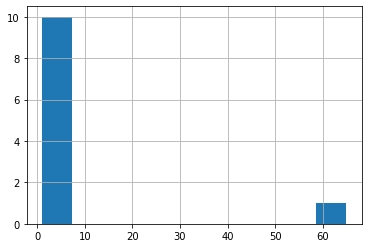

In [26]:
df[df['album_id']==7225]['profile_id'].value_counts().hist()

In [19]:
df = pd.merge(df,buy_df[['profile_id','album_id','payment']].drop_duplicates(), 'left', on = ['profile_id','album_id'])
pd.merge(df, search_df[['profile_id','album_id']]

,profile_id,log_time,album_id,sex,age,title,sub_title,genre_large,genre_mid,genre_small,...,onair_date,cast_1,cast_2,cast_3,cast_4,cast_5,cast_6,cast_7,views,payment
0,3,20220301115719,15,F,5,거미,핑크퐁 3D율동동요,키즈,노래율동,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,NaN
1,3,20220301115809,16,F,5,상어 가족,노래율동,키즈,노래율동,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,NaN
2,3,20220301115809,16,F,5,상어 가족,핑크퐁 3D율동동요,키즈,노래율동,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,NaN
3,3,20220301115958,17,F,5,작은 별,핑크퐁 3D율동동요,키즈,노래율동,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,NaN
4,3,20220301120118,18,F,5,작은 주전자에요,만 3세를 위한 영상,키즈,노래율동,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275375,33032,20220427155668,381,F,5,할머니의 용궁여행,6-7세,키즈,책,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,186,NaN
1275376,33032,20220427155680,381,F,5,할머니의 용궁여행,6-7세,키즈,책,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,186,NaN
1275377,33032,20220427155810,125,F,5,응가공주,4-5세,키즈,책,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,186,NaN
1275378,33032,20220427155838,125,F,5,응가공주,4-5세,키즈,책,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,186,NaN


In [ ]:
data = df[['profile_id','log_time','album_id','views']].drop_duplicates(subset=['profile_id', 'album_id', 'log_time']).sort_values(by = ['profile_id', 'log_time']).reset_index(drop = True)
data['rating'] = 1
data.shape

(899252, 5)

In [ ]:
# 데이터 전처리 (중복제거) 
# 참고 : drop_duplicates의 subset을 무엇으로 구성하냐에 따라서 제거되는 항목들이 다름 
# ex) 'profile_id', 'album_id' : 중복된 시청이력 모두 제거 / 'profile_id', 'album_id', 'log_time' : 같은 시간에 시청한 이력만 제거 
data = df[['profile_id','log_time','album_id']].drop_duplicates(subset=['profile_id', 'album_id', 'log_time']).sort_values(by = ['profile_id', 'log_time']).reset_index(drop = True)
data['rating'] = 1
data.shape

(899252, 4)

In [ ]:
data.head(3)

,profile_id,log_time,album_id,views,rating
0,3,20220301115719,15,23,1
1,3,20220301115809,16,23,1
2,3,20220301115958,17,23,1


In [ ]:
cfg.n_users = data.profile_id.max()+1
cfg.n_items = data.album_id.max()+1

In [ ]:
# 학습 및 검증 데이터 분리
train, valid = train_test_split(
    data, test_size=cfg.test_size, random_state=cfg.seed,
)
print('학습 데이터 크기:', train.shape)
print('검증 데이터 크기:', valid.shape)

학습 데이터 크기: (719401, 5)
검증 데이터 크기: (179851, 5)


In [ ]:
sparse.lil_matrix((cfg.n_users, cfg.n_items))

<33033x25917 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in List of Lists format>

In [ ]:
# Matrix 형태로 변환 
train = train.to_numpy()
matrix = sparse.lil_matrix((cfg.n_users, cfg.n_items))
for (p, _, i, r, view) in tqdm(train):
    matrix[p, i] = r
    
train = sparse.csr_matrix(matrix)
train = train.toarray()
print("train 형태: \n", train)

  0%|          | 0/719401 [00:00<?, ?it/s]

train 형태: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
df.columns

Index(['profile_id', 'log_time', 'album_id', 'continuous_play', 'sex', 'age',
       'title', 'sub_title', 'genre_large', 'genre_mid', 'genre_small',
       'country', 'run_time', 'onair_date', 'cast_1', 'cast_2', 'cast_3',
       'cast_4', 'cast_5', 'cast_6', 'cast_7', 'views'],
      dtype='object')

In [ ]:
# 유저 특징 정보 추출 
df = df.set_index('profile_id')
user_features = df[['age']].to_dict()
# # 성별, view, continuous 추가
df['sex'] = df['sex'].map(lambda x: 1 if x == 'M' else 0)
user_features_sex = df[['sex']].to_dict()
user_features_views = df[['views']].to_dict()
print("user_id 3의 age 정보 :", user_features['age'][3])
print("user_id 3의 age 정보 :", user_features_sex['sex'][3])
print("user_id 3의 age 정보 :", user_features_views['views'][3])

user_id 3의 age 정보 : 5
user_id 3의 age 정보 : 0
user_id 3의 age 정보 : 23


In [ ]:
df.shape

(1275380, 22)

In [ ]:
meta_df.head(3)

,album_id,title,sub_title,genre_large,genre_mid,genre_small,country,run_time,onair_date,cast_1,cast_2,cast_3,cast_4,cast_5,cast_6,cast_7
0,749,어둠이 무서워요,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
1,750,우리는 친구,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
2,2131,타요의 첫 운행,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN


In [ ]:
# 아이템 특징 정보 추출 
# meta_df = meta_df.set_index('album_id')

# 범주형 데이터를 수치형 데이터로 변경 
le = LabelEncoder()
meta_df['genre_mid'] = le.fit_transform(meta_df['genre_mid'])
# meta['run_time']= meta['run_time'].map(lambda x: np.log10(x)+1)
item_features = meta_df[['genre_mid']].to_dict()
item_features_run = meta_df[['run_time']].to_dict()
print("album_id 749의 genre_mid 정보 :", item_features['genre_mid'][749])
print("album_id 749의 run_time 정보 :", item_features_run['run_time'][749])

album_id 749의 genre_mid 정보 : 5
album_id 749의 run_time 정보 : 539


In [ ]:
df.columns

Index(['log_time', 'album_id', 'sex', 'age', 'genre_mid', 'run_time', 'views'], dtype='object')

In [ ]:
# 추출한 특징 정보의 속성을 저장 
cfg.n_genres = meta_df['genre_mid'].nunique()
cfg.n_sex = df['sex'].nunique()
cfg.n_continuous_feats = 3 

## NeuMF 구현


### 모델 구현 
- [Neural Collaborative Filtering(NCF)](https://arxiv.org/pdf/1708.05031.pdf) 논문의 NeuMF를 참고하여 side-information을 결합한 모델을 PyTorch로 구현
    - continuous feature (age)와 categorical feature (genre_mid)를 같이 학습할 수 있도록 결합

![](http://drive.google.com/uc?export=view&id=1tpajTLipLoFdvLICO-alAxeoKAE8-k61)

In [ ]:
df.columns

Index(['log_time', 'album_id', 'sex', 'age', 'genre_mid', 'run_time', 'views'], dtype='object')

In [ ]:
class NeuMF(nn.Module):
    """Neural Matrix Factorization Model
        참고 문헌 : https://arxiv.org/abs/1708.05031

    예시 :
        model = NeuMF(cfg) 
        output = model.forward(user_ids, item_ids, [feat0, feat1]) 
    """
    def __init__(self, cfg):
        """ 
        Args:
            cfg : config 파일로 네트워크 생성에 필요한 정보들을 담고 있음 
        """
        super(NeuMF, self).__init__()
        self.n_users = cfg.n_users
        self.n_items = cfg.n_items
        self.emb_dim = cfg.emb_dim
        self.layer_dim = cfg.layer_dim
        self.n_continuous_feats = cfg.n_continuous_feats
        self.n_genres = cfg.n_genres
        self.n_sex = cfg.n_sex
        self.dropout = cfg.dropout
        self.build_graph()

    def build_graph(self):
        """Neural Matrix Factorization Model 생성
            구현된 모습은 위의 그림을 참고 
        """
        # mf용 유저임베딩 - 유저 임베딩 수 == 유저 cfg 수, 임베딩 차원 수 == 256 
        self.user_embedding_mf = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.emb_dim)
        self.item_embedding_mf = nn.Embedding(num_embeddings=self.n_items, embedding_dim=self.emb_dim)
        
        # mlp 용 유저 임베딩, 차원 수도 동일한 방법
        self.user_embedding_mlp = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.emb_dim)
        self.item_embedding_mlp = nn.Embedding(num_embeddings=self.n_items, embedding_dim=self.emb_dim)
                
        # mlp 용 특성 장르 임베딩도 설정
        self.genre_embeddig = nn.Embedding(num_embeddings=self.n_genres, embedding_dim=self.n_genres//2)
        # mlp 용 특성 성별 임베딩도 설정
        self.sex_embeddig = nn.Embedding(num_embeddings=self.n_sex, embedding_dim=self.n_sex//2)
        
        # mlp 레이어 - 시퀜셜 모델로 생성
        self.mlp_layers = nn.Sequential(
            # 첫번째 인자값은 input size, 두번째 인자값은 output size이다
            nn.Linear(2*self.emb_dim + self.n_genres//2 + self.n_sex//2 + self.n_continuous_feats, self.layer_dim), 
            nn.ReLU(), 
            nn.Dropout(p=self.dropout), 
            nn.Linear(self.layer_dim, self.layer_dim//2), 
            nn.ReLU(), 
            nn.Dropout(p=self.dropout)
        )
        
        self.affine_output = nn.Linear(self.layer_dim//2 + self.emb_dim, 1)
        self.apply(self._init_weights)
        

    def _init_weights(self, module):
        if isinstance(module, nn.Embedding):
            normal_(module.weight.data, mean=0.0, std=0.01)
        elif isinstance(module, nn.Linear):
            normal_(module.weight.data, 0, 0.01)
            if module.bias is not None:
                module.bias.data.fill_(0.0)
    
    def forward(self, user_indices, item_indices, feats):
        """ 
        Args:
            user_indices : 유저의 인덱스 정보 
                ex) tensor([ 3100,  3100,  ..., 14195, 14195])
            item_indices : 아이템의 인덱스 정보
                ex) tensor([   50,    65,   ..., 14960, 11527])
            feats : 특징 정보 
        Returns: 
            output : 유저-아이템 쌍에 대한 추천 결과 
                ex) tensor([  9.4966,  22.0261, ..., -19.3535, -23.0212])
        """
        # 임베딩 진행
        user_embedding_mf = self.user_embedding_mf(user_indices)
        item_embedding_mf = self.item_embedding_mf(item_indices)
        mf_output = torch.mul(user_embedding_mf, item_embedding_mf)
        
        user_embedding_mlp = self.user_embedding_mlp(user_indices)
        item_embedding_mlp = self.item_embedding_mlp(item_indices)
        genre_embedding_mlp = self.genre_embeddig(feats[3])


        #런타임 임베딩 추가
        sex_embedding_mlp = self.sex_embeddig(feats[2])
        input_feature = torch.cat((user_embedding_mlp, item_embedding_mlp, genre_embedding_mlp, sex_embedding_mlp, feats[0].unsqueeze(1), feats[1].unsqueeze(1),feats[4].unsqueeze(1)), -1)
        mlp_output = self.mlp_layers(input_feature)
        
        output = torch.cat([mlp_output, mf_output], dim=-1)
        output = self.affine_output(output).squeeze(-1)
        return output

### 학습 및 추론 코드 구현

- 학습 : Negative sampling을 활용하여 Binary Classification 진행 
    - history 에 있는 album_id는 positive label로 그렇지 않은 album_id는 nagative label로 활용  
    - 단, 이때 모든 album_id를 negative label로 활용하는 것이 아닌 일부만 사용 (neg_ratio 값에 따라서 개수 조정)
- 추론 : 일부 데이터에 대해 recall, ndcg, coverage 성능 확인

#### 학습 및 추론에 필요한 데이터 셋 생성 코드 구현

In [ ]:
UIdataset = {}
neg_ratio = cfg.neg_ratio
for user_id, items_by_user in enumerate(train):
    UIdataset[user_id] = []
    # positive 샘플 계산 
    # pos item은 0.5 이상인 것들의 index를 찾아 출력
    pos_item_ids = np.where(items_by_user > 0.5)[0]
    # pos 샘플 개수
    num_pos_samples = len(pos_item_ids)

    # negative 샘플 계산 (random negative sampling)
    # neg 샘플 개수 
    num_neg_samples = neg_ratio * num_pos_samples
    neg_items = np.where(items_by_user < 0.5)[0]
    # neg 샘플 중 랜덤 초이스
    neg_item_ids = np.random.choice(neg_items, min(num_neg_samples, len(neg_items)), replace=False)
    # pos, neg 샘플 짝지어서 UIdataset에 넣기
    UIdataset[user_id].append(np.concatenate([pos_item_ids, neg_item_ids]))
    

In [ ]:
def make_UIdataset(train, neg_ratio):
    """ 유저별 학습에 필요한 딕셔너리 데이터 생성 
    Args:
        train : 유저-아이템의 상호작용을 담은 행렬 
            ex) 
                array([[0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        ...,
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.]])
        neg_ratio : negative sampling 활용할 비율 
            ex) 3 (positive label 1개당 negative label 3개)
    Returns: 
        UIdataset : 유저별 학습에 필요한 정보를 담은 딕셔너리 
            ex) {'사용자 ID': [[positive 샘플, negative 샘플], ... , [1, 1, 1, ..., 0, 0]]}
                >>> UIdataset[3]
                    [array([   16,    17,    18, ...,  9586, 18991,  9442]),
                    array([5, 5, 5, ..., 5, 5, 5]),
                    array([4, 4, 4, ..., 5, 1, 1]),
                    array([1., 1., 1., ..., 0., 0., 0.])]
    """
    UIdataset = {}
    for user_id, items_by_user in enumerate(train):
        UIdataset[user_id] = []
        # positive 샘플 계산 
        # pos item은 0.5 이상인 것들의 index를 찾아 출력
        pos_item_ids = np.where(items_by_user > 0.5)[0]
        # pos 샘플 개수
        num_pos_samples = len(pos_item_ids)

        # negative 샘플 계산 (random negative sampling)
        # neg 샘플 개수 
        num_neg_samples = neg_ratio * num_pos_samples
        neg_items = np.where(items_by_user < 0.5)[0]
        # neg 샘플 중 랜덤 초이스
        neg_item_ids = np.random.choice(neg_items, min(num_neg_samples, len(neg_items)), replace=False)
        # pos, neg 샘플 짝지어서 UIdataset에 넣기
        UIdataset[user_id].append(np.concatenate([pos_item_ids, neg_item_ids]))
        
        # feature 추출 
        features_age = []
        features_views = []
        features_sex = []
        # pos, neg 쌍을 하나씩 뽑고,
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            # user_features의 user에 따른 나이를 features에 넣기
            features_age.append(user_features['age'][user_id])  # float
            features_views.append(user_features_views['views'][user_id])  # float
            features_sex.append(user_features_sex['sex'][user_id])  # long
        #나이 정보 순서를 append해서 모든 쌍에 추가해주기
        UIdataset[user_id].append(np.array(features_age))
        UIdataset[user_id].append(np.array(features_views))
        UIdataset[user_id].append(np.array(features_sex))

        features_genre = []
        features_run = []
        # pos와 neg 일렬 리스트로 변환
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            # item_features의 item에 따른 장르를 features에 넣기
            features_genre.append(item_features['genre_mid'][item_id])  # long
            features_run.append(item_features_run['run_time'][item_id]) # float
        #장르 정보를 append해서 모든 쌍에 추가해주기 -> 상호작용에 feature가 추가된것임
        UIdataset[user_id].append(np.array(features_genre))
        UIdataset[user_id].append(np.array(features_run))
        
        # label 저장  
        pos_labels = np.ones(len(pos_item_ids))
        neg_labels = np.zeros(len(neg_item_ids))
        UIdataset[user_id].append(np.concatenate([pos_labels, neg_labels]))

    return UIdataset

In [ ]:
UIdataset_b = make_UIdataset(train_b, neg_ratio=cfg.neg_ratio)

In [ ]:
def make_batchdata(user_indices, batch_idx, batch_size):
    """ 배치 데이터로 변환 
    Args:
        user_indices : 전체 유저의 인덱스 정보 
            ex) array([ 3100,  1800, 30098, ...,  2177, 11749, 20962])
        batch_idx : 배치 인덱스 (몇번째 배치인지)
            ex) 0 
        batch_size : 배치 크기 
            ex) 256 
    Returns 
        batch_user_ids : 배치내의 유저 인덱스 정보 
            ex) [22194, 22194, 22194, 22194, 22194, ...]
        batch_item_ids : 배치내의 아이템 인덱스 정보 
            ex) [36, 407, 612, 801, 1404, ...]
        batch_feat0 : 배치내의 유저-아이템 인덱스 정보에 해당하는 feature0 정보 
            ex) [6, 6, 6, 6, 6, ...]
        batch_feat1 : 배치내의 유저-아이템 인덱스 정보에 해당하는 feature1 정보 
            ex) [4,  4,  4, 23,  4, ...]
        batch_labels : 배치내의 유저-아이템 인덱스 정보에 해당하는 label 정보 
            ex) [1.0, 1.0, 1.0, 1.0, 1.0, ...]
    """
    batch_user_indices = user_indices[batch_idx*batch_size : (batch_idx+1)*batch_size]
    batch_user_ids = []
    batch_item_ids = []
    batch_feat0 = []  # age
    batch_feat1 = []  # views
    batch_feat2 = []  # sex 
    batch_feat3 = []  # genre
    batch_feat4 = []  # runtime
    batch_labels = [] # label
    for user_id in batch_user_indices:
        item_ids = UIdataset[user_id][0]
        feat0 = UIdataset[user_id][1]
        feat1 = UIdataset[user_id][2]
        feat2 = UIdataset[user_id][3]
        feat3 = UIdataset[user_id][4]
        feat4 = UIdataset[user_id][5]
        labels = UIdataset[user_id][6]
        user_ids = np.full(len(item_ids), user_id)  # 모든 값을 user_id로 통일
        batch_user_ids.extend(user_ids.tolist())
        batch_item_ids.extend(item_ids.tolist())
        batch_feat0.extend(feat0.tolist())
        batch_feat1.extend(feat1.tolist())
        batch_feat2.extend(feat2.tolist())
        batch_feat3.extend(feat3.tolist())
        batch_feat4.extend(feat4.tolist())      
        batch_labels.extend(labels.tolist())
    return batch_user_ids, batch_item_ids, batch_feat0, batch_feat1, batch_feat2, batch_feat3, batch_feat4, batch_labels

def update_avg(curr_avg, val, idx):
    """ 현재 epoch 까지의 평균 값을 계산 
    """
    return (curr_avg * idx + val) / (idx + 1)

#### 학습 및 검증 코드 생성

In [ ]:
def train_epoch(cfg, model, optimizer, criterion): 
    model.train()
    curr_loss_avg = 0.0

    user_indices = np.arange(cfg.n_users)
    np.random.RandomState(cfg.epoch).shuffle(user_indices)
    batch_num = int(len(user_indices) / cfg.batch_size) + 1
    bar = tqdm(range(batch_num), leave=False)
    for step, batch_idx in enumerate(bar):
        user_ids, item_ids, feat0, feat1,feat2, feat3, feat4, labels = make_batchdata(user_indices, batch_idx, cfg.batch_size)
        # 배치 사용자 단위로 학습
        user_ids = torch.LongTensor(user_ids).to(cfg.device)
        item_ids = torch.LongTensor(item_ids).to(cfg.device)
        feat0 = torch.FloatTensor(feat0).to(cfg.device)
        feat1 = torch.FloatTensor(feat1).to(cfg.device)
        feat2 = torch.LongTensor(feat2).to(cfg.device)
        feat3 = torch.LongTensor(feat3).to(cfg.device)
        feat4 = torch.FloatTensor(feat4).to(cfg.device)
        labels = torch.FloatTensor(labels).to(cfg.device)
        labels = labels.view(-1, 1)

        # grad 초기화
        optimizer.zero_grad()

        # 모델 forward
        output = model.forward(user_ids, item_ids, [feat0, feat1, feat2, feat3, feat4])
        output = output.view(-1, 1)

        loss = criterion(output, labels)

        # 역전파
        loss.backward()

        # 최적화
        optimizer.step()    
        if torch.isnan(loss):
            print('Loss NAN. Train finish.')
            break
        curr_loss_avg = update_avg(curr_loss_avg, loss, step)
        
        msg = f"epoch: {cfg.epoch}, "
        msg += f"loss: {curr_loss_avg.item():.5f}, "
        msg += f"lr: {optimizer.param_groups[0]['lr']:.6f}"
        bar.set_description(msg)
    rets = {'losses': np.around(curr_loss_avg.item(), 5)}
    return rets

In [ ]:
def recallk(actual, predicted, k = 25):
    """ label과 prediction 사이의 recall 평가 함수 
    Args:
        actual : 실제로 본 상품 리스트
        pred : 예측한 상품 리스트
        k : 상위 몇개의 데이터를 볼지 (ex : k=5 상위 5개의 상품만 봄)
    Returns: 
        recall_k : recall@k 
    """ 
    set_actual = set(actual)
    recall_k = len(set_actual & set(predicted[:k])) / min(k, len(set_actual))
    return recall_k

def unique(sequence):
    # preserves order
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

def ndcgk(actual, predicted, k = 25):
    set_actual = set(actual)
    idcg = sum([1.0 / np.log(i + 2) for i in range(min(k, len(set_actual)))])
    dcg = 0.0
    unique_predicted = unique(predicted[:k])
    for i, r in enumerate(unique_predicted):
        if r in set_actual:
            dcg += 1.0 / np.log(i + 2)
    ndcg_k = dcg / idcg
    return ndcg_k

def evaluation(gt, pred):
    """ label과 prediction 사이의 recall, coverage, competition metric 평가 함수 
    Args:
        gt : 데이터 프레임 형태의 정답 데이터 
        pred : 데이터 프레임 형태의 예측 데이터 
    Returns: 
        rets : recall, ndcg, coverage, competition metric 결과 
            ex) {'recall': 0.123024, 'ndcg': 056809, 'coverage': 0.017455, 'score': 0.106470}
    """    
    gt = gt.groupby('profile_id')['album_id'].unique().to_frame().reset_index()
    gt.columns = ['profile_id', 'actual_list']

    evaluated_data = pd.merge(pred, gt, how = 'left', on = 'profile_id')

    evaluated_data['Recall@25'] = evaluated_data.apply(lambda x: recallk(x.actual_list, x.predicted_list), axis=1)
    evaluated_data['NDCG@25'] = evaluated_data.apply(lambda x: ndcgk(x.actual_list, x.predicted_list), axis=1)

    recall = evaluated_data['Recall@25'].mean()
    ndcg = evaluated_data['NDCG@25'] .mean()
    coverage = (evaluated_data['predicted_list'].apply(lambda x: x[:cfg.top_k]).explode().nunique())/meta_df.index.nunique()

    score = 0.75*recall + 0.25*ndcg
    rets = {"recall" :recall, 
            "ndcg" :ndcg, 
            "coverage" :coverage, 
            "score" :score}
    return rets

In [ ]:
query_user_ids = data_small['profile_id'].unique()

In [ ]:
full_item_ids = np.array([c for c in range(cfg.n_items)])
full_item_ids_feat3 = [item_features['genre_mid'][c] for c in full_item_ids]
full_item_ids_feat4 = [item_features_run['run_time'][c] for c in full_item_ids]

In [ ]:
len(full_item_ids_feat4)

25917

In [ ]:
for user_id in query_user_ids:
        # 텐서에 연산 기록을 중지하고, 학습된 모델로 inference하는 과정
        with torch.no_grad():
            user_ids = np.full(cfg.n_items, user_id)
            
            user_ids = torch.LongTensor(user_ids).to(cfg.device)
            item_ids = torch.LongTensor(full_item_ids).to(cfg.device)
            
            feat0 = np.full(cfg.n_items, user_features['age'][user_id])
            feat0 = torch.FloatTensor(feat0).to(cfg.device)
            feat1 = np.full(cfg.n_items, user_features_views['views'][user_id])
            feat1 = torch.FloatTensor(feat1).to(cfg.device)
            feat2 = np.full(cfg.n_items, user_features_sex['sex'][user_id])
            feat2 = torch.LongTensor(feat2).to(cfg.device)
            feat3 = torch.LongTensor(full_item_ids_feat3).to(cfg.device)
            feat4 = torch.FloatTensor(full_item_ids_feat4).to(cfg.device)
                
            print(user_ids)
            print(item_ids)
            print(feat0)
            print(feat1)
            print(user_ids.shape)
            print(item_ids.shape)
            print(feat0.shape)
            print(feat1.shape)
            break
            # print(user_ids)
            # # detach로 validation set에 대한 그래프 history 차단 후 inference
            # eval_output = model.forward(user_ids, item_ids, [feat0, feat1]).detach().cpu().numpy()
            # pred_u_score = eval_output.reshape(-1)   
      

In [ ]:
model = NeuMF(cfg).to(cfg.device)

In [ ]:
pred_list = []
model.eval()
for user_id in query_user_ids:
        # 텐서에 연산 기록을 중지하고, 학습된 모델로 inference하는 과정
        with torch.no_grad():
            user_ids = np.full(cfg.n_items, user_id)
            # 유저를 특정하고, 해당 유저에 대한 나이 설정 후, 선택된 아이템에 대한 아이템 id, 아이템 장르를 추가해 추론
            user_ids = torch.LongTensor(user_ids).to(cfg.device)
            item_ids = torch.LongTensor(full_item_ids).to(cfg.device)
      
            feat0 = np.full(cfg.n_items, user_features['age'][user_id])
            feat0 = torch.FloatTensor(feat0).to(cfg.device)
            feat1 = np.full(cfg.n_items, user_features_views['views'][user_id])
            feat1 = torch.FloatTensor(feat1).to(cfg.device)
            feat2 = np.full(cfg.n_items, user_features_sex['sex'][user_id])
            feat2 = torch.LongTensor(feat2).to(cfg.device)
            feat3 = torch.LongTensor(full_item_ids_feat3).to(cfg.device)
            feat4 = torch.FloatTensor(full_item_ids_feat4).to(cfg.device)
            # detach로 validation set에 대한 그래프 history 차단 후 inference
            eval_output = model.forward(user_ids, item_ids, [feat0, feat1, feat2, feat3, feat4]).detach().cpu().numpy()
            # 특정 유저의 각 아이템에 대한 스코어를 추론하게 되었음.
            pred_u_score = eval_output.reshape(-1)   
        
        # 스코어가 높은 순서대로 인덱스를 뽑는다
        # np.argsort(pred_u_score)[::-1]         # 최종 스코어에서 user idx를 높은 score 순서대로 뽑기
        # print(pred_u_idx)
        # pred_u = full_item_ids[pred_u_idx]                  # 전체 아이템 중 score가 높은 
        # print(pred_u)
        # pred_list.append(list(pred_u[:cfg.top_k]))
        # print(pred_u[:cfg.top_k])
        break


25917
25917
12959


In [ ]:
def valid_epoch(cfg, model, data, mode='valid'):
    pred_list = []
    model.eval()
    
    query_user_ids = data['profile_id'].unique() # 추론할 모든 user array 집합
    full_item_ids = np.array([c for c in range(cfg.n_items)]) # 추론할 모든 item array 집합 
    full_item_ids_feat1 = [item_features['genre_mid'][c] for c in full_item_ids]
    for user_id in query_user_ids:
        # 텐서에 연산 기록을 중지하고, 학습된 모델로 inference하는 과정
        with torch.no_grad():
            user_ids = np.full(cfg.n_items, user_id)
            
            user_ids = torch.LongTensor(user_ids).to(cfg.device)
            item_ids = torch.LongTensor(full_item_ids).to(cfg.device)
            
            feat0 = np.full(cfg.n_items, user_features['age'][user_id])
            feat0 = torch.FloatTensor(feat0).to(cfg.device)
            feat1 = np.full(cfg.n_items, user_features_views['views'][user_id])
            feat1 = torch.FloatTensor(feat1).to(cfg.device)
            feat2 = np.full(cfg.n_items, user_features_sex['sex'][user_id])
            feat2 = torch.LongTensor(feat2).to(cfg.device)
            feat3 = torch.LongTensor(full_item_ids_feat3).to(cfg.device)
            feat4 = torch.FloatTensor(full_item_ids_feat4).to(cfg.device)
            # detach로 validation set에 대한 그래프 history 차단 후 inference
            eval_output = model.forward(user_ids, item_ids, [feat0, feat1, feat2, feat3, feat4]).detach().cpu().numpy()
            pred_u_score = eval_output.reshape(-1)   
        

        pred_u_idx = np.argsort(pred_u_score)[::-1]         # 최종 스코어 높은 순서대로 인덱스 뽑기
        pred_u = full_item_ids[pred_u_idx]                  # 전체 아이템 중에서 스코어가 높은 인덱스들 뽑아 리스트 가져오기
        pred_list.append(list(pred_u[:cfg.top_k]))          # top_k개 만큼을 pred_list에 넣기
        
    pred = pd.DataFrame()
    pred['profile_id'] = query_user_ids
    pred['predicted_list'] = pred_list
    
    # 모델 성능 확인 
    if mode == 'valid':
        rets = evaluation(data, pred)
        return rets, pred
    return pred

## 모델 학습

### 하이퍼파라미터 설정 & 최적화 기법 설정

In [ ]:
# 하이퍼 파라미터 설정 
cfg.batch_size = 256
cfg.emb_dim = 256
cfg.layer_dim = 256
cfg.dropout = 0.05
cfg.epochs = 25
cfg.learning_rate = 0.0025
cfg.reg_lambda = 0
cfg.check_epoch = 1

In [ ]:
# model 생성 및 optimizer, loss 함수 설정 
model = NeuMF(cfg).to(cfg.device)
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate, weight_decay=cfg.reg_lambda)
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')

### 학습 진행

In [ ]:
total_logs = defaultdict(list)
best_scores  = 0
for epoch in range(cfg.epochs+1):
    cfg.epoch = epoch
    train_results = train_epoch(cfg, model, optimizer, criterion)
    
    # cfg.check_epoch 번의 epoch 마다 성능 확인 
    if epoch % cfg.check_epoch == 0: 
        valid_results, _ = valid_epoch(cfg, model, valid)

        logs = {
            'Train Loss': train_results['losses'],
            f'Valid Recall@{cfg.top_k}': valid_results['recall'],
            f'Valid NDCG@{cfg.top_k}': valid_results['ndcg'],
            'Valid Coverage': valid_results['coverage'],
            'Valid Score': valid_results['score'],
            }

        # 검증 성능 확인 
        for key, value in logs.items():
            total_logs[key].append(value)

        if epoch == 0:
            print("Epoch", end=",")
            print(",".join(logs.keys()))

        print(f"{epoch:02d}  ", end="")
        print("  ".join([f"{v:0.6f}" for v in logs.values()]))
        
        # 가장 성능이 좋은 가중치 파일을 저장 
        if best_scores <= valid_results['score']: 
            best_scores = valid_results['score']
            torch.save(model.state_dict(), os.path.join('/content/drive/MyDrive/code/saved', 'model(best_scores).pth'))

  0%|          | 0/130 [00:00<?, ?it/s]

Epoch,Train Loss,Valid Recall@25,Valid NDCG@25,Valid Coverage,Valid Score
00  18724.128910  0.143093  0.107927  0.000915  0.134301


  0%|          | 0/130 [00:00<?, ?it/s]

01  10318.009770  0.211102  0.169435  0.004155  0.200685


  0%|          | 0/130 [00:00<?, ?it/s]

02  8430.565430  0.352516  0.262686  0.052486  0.330058


  0%|          | 0/130 [00:00<?, ?it/s]

03  6536.504880  0.441410  0.326732  0.117436  0.412741


  0%|          | 0/130 [00:00<?, ?it/s]

04  4646.181150  0.477138  0.348352  0.191376  0.444942


  0%|          | 0/130 [00:00<?, ?it/s]

05  3418.645020  0.486039  0.349074  0.256443  0.451797


  0%|          | 0/130 [00:00<?, ?it/s]

06  2161.892330  0.497337  0.358926  0.289470  0.462734


  0%|          | 0/130 [00:00<?, ?it/s]

07  1438.207400  0.496041  0.358315  0.303178  0.461609


  0%|          | 0/130 [00:00<?, ?it/s]

08  962.691710  0.498128  0.357968  0.322497  0.463088


  0%|          | 0/130 [00:00<?, ?it/s]

09  654.786500  0.497777  0.358404  0.327097  0.462934


  0%|          | 0/130 [00:00<?, ?it/s]

10  462.178770  0.498011  0.358347  0.330501  0.463095


  0%|          | 0/130 [00:00<?, ?it/s]

11  369.965390  0.496400  0.356782  0.332825  0.461496


  0%|          | 0/130 [00:00<?, ?it/s]

12  279.420620  0.497313  0.357749  0.335947  0.462422


  0%|          | 0/130 [00:00<?, ?it/s]

13  214.491530  0.496878  0.357028  0.336252  0.461915


  0%|          | 0/130 [00:00<?, ?it/s]

14  167.066480  0.495627  0.355648  0.342590  0.460632


  0%|          | 0/130 [00:00<?, ?it/s]

15  139.868010  0.496814  0.356338  0.340641  0.461695


  0%|          | 0/130 [00:00<?, ?it/s]

16  117.169480  0.495250  0.354192  0.357495  0.459985


  0%|          | 0/130 [00:00<?, ?it/s]

17  86.733990  0.495702  0.355585  0.342331  0.460672


  0%|          | 0/130 [00:00<?, ?it/s]

18  60.342660  0.495974  0.355733  0.337778  0.460914


  0%|          | 0/130 [00:00<?, ?it/s]

19  45.655890  0.496526  0.355938  0.334656  0.461379


  0%|          | 0/130 [00:00<?, ?it/s]

20  38.038260  0.496093  0.355780  0.334491  0.461014


  0%|          | 0/130 [00:00<?, ?it/s]

21  32.438850  0.496606  0.356116  0.334045  0.461483


  0%|          | 0/130 [00:00<?, ?it/s]

22  27.997270  0.495790  0.355555  0.334233  0.460731


  0%|          | 0/130 [00:00<?, ?it/s]

23  24.337660  0.495996  0.355572  0.331792  0.460890


  0%|          | 0/130 [00:00<?, ?it/s]

24  21.331960  0.496260  0.355780  0.331064  0.461140


  0%|          | 0/130 [00:00<?, ?it/s]

25  18.737940  0.495878  0.355721  0.331440  0.460838


### 학습 과정 시각화

In [ ]:
train_scores = pd.DataFrame({'Train loss': total_logs['Train Loss']})
train_scores['Epoch'] = range(0, cfg.epochs+1, cfg.check_epoch)

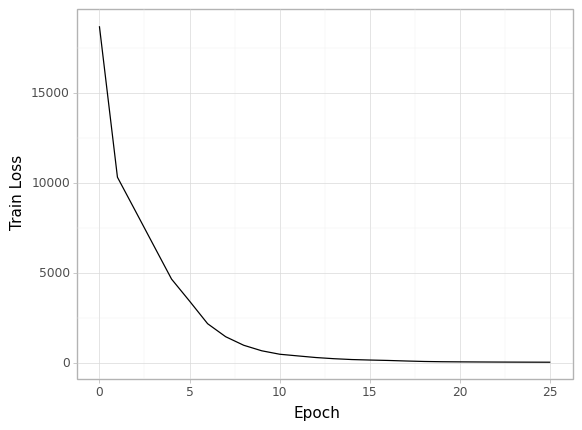

<ggplot: (8785218158029)>

In [ ]:
(
    ggplot(train_scores, aes(x='Epoch', y='Train loss'))+ geom_line(color='black') # line plot
        + labs(x='Epoch', y='Train Loss')
        + theme_light()
)

In [ ]:
valid_scores = pd.DataFrame(np.hstack([(range(0, cfg.epochs+1, cfg.check_epoch), total_logs[score], [score for i in range(0, cfg.epochs+1, cfg.check_epoch)]) for score in ['Valid Recall@25', 'Valid NDCG@25', 'Valid Coverage', 'Valid Score']])).T
valid_scores.columns = ['Epoch', 'Score', 'Metric']
valid_scores['Epoch'] = valid_scores['Epoch'].astype(int)
valid_scores['Score'] = valid_scores['Score'].astype(float)

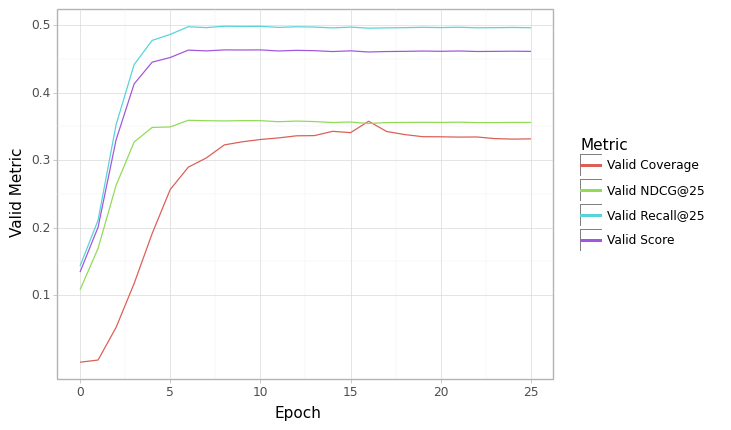

<ggplot: (8785690054369)>

In [ ]:
(
ggplot(valid_scores)  # here
    + aes("Epoch", "Score", color='Metric', group='Metric')
    + geom_line()
    + scale_y_continuous(breaks=[0.1*c for c in range(1, 10, 1)])
    + theme_light()
    + labs(x='Epoch', y='Valid Metric')
)  

## 제출 
### 모든 유저에 대해 추천 결과 생성

In [ ]:
model.load_state_dict(torch.load(os.path.join('/content/drive/MyDrive/code/saved', 'model(best_scores).pth')))

<All keys matched successfully>

In [ ]:
submission_path = os.path.join('/content/drive/MyDrive/data', 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission = valid_epoch(cfg, model, submission, mode='test')

### 저장

In [ ]:
submission.to_csv(os.path.join('/content', 'submission1.csv'), index = False)

In [ ]:
valid.shape

(179851, 4)

In [ ]:
df.columns

Index(['log_time', 'album_id', 'sex', 'age', 'title', 'sub_title',
       'genre_large', 'genre_mid', 'genre_small', 'country', 'run_time',
       'onair_date', 'cast_1', 'cast_2', 'cast_3', 'cast_4', 'cast_5',
       'cast_6', 'cast_7', 'views'],
      dtype='object')

In [ ]:
valid_df = pd.merge(valid, df[['profile_id','views']], "left", on = 'profile_id')
valid_df.shape

In [ ]:
val_pred = valid_epoch(cfg, model, valid)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

classification_report(val_pred)